## STEP 1: Fetching the **data**

In [2]:
import os
import numpy as np
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

## STEP 2: Quick **exploration** of dataset

In [3]:
import pandas as pd

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing_df = load_housing_data()

In [8]:
housing_df.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY

In [9]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing_df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

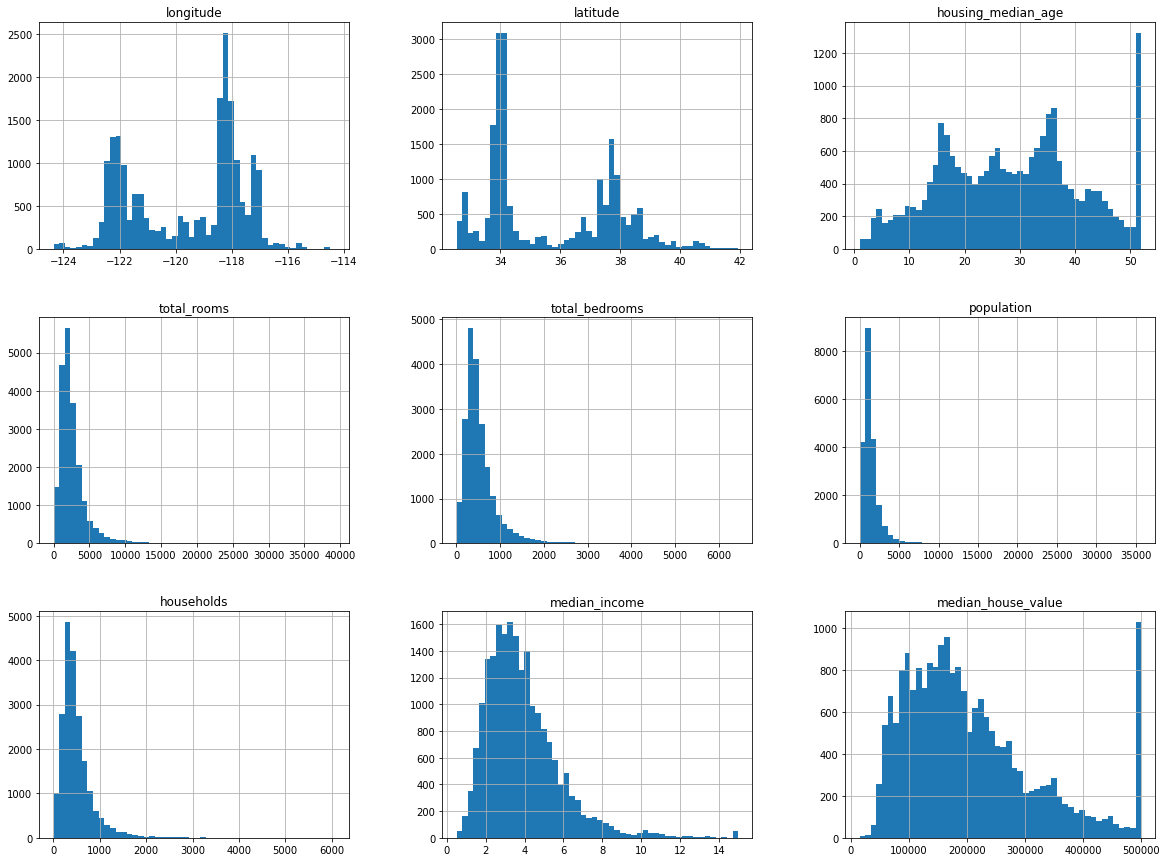

In [13]:
housing_df.hist(bins=50, figsize=(20,15))
plt.show()

## STEP 3: Spliting Data into **training and test sets: stratified sampling** to avoid bias

In [6]:
from sklearn.model_selection import train_test_split

In [15]:
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

In [16]:
test_set.shape

(4128, 10)

In [17]:
housing_df['income_cat'] = pd.cut(
    housing_df['median_income'], 
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
    labels=[1,2,3,4,5]
)

In [18]:
housing_df.get("income_cat").unique()

[5, 4, 3, 2, 1]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

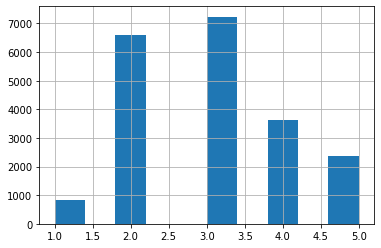

In [19]:
housing_df.get('income_cat').hist()
plt.show()

#### Using sklearn cross-validator to split

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [22]:
for train_index, test_index in split.split(housing_df, housing_df.get('income_cat')):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [23]:
for train_index, test_index in split.split(housing_df, housing_df.get('income_cat')):
    print(type(train_index), type(test_index))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [24]:
strat_test_set.get('income_cat').value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## STEP 4: **Visualizing** parts of training data **for insights**

In [26]:
viz_df = strat_train_set.copy()

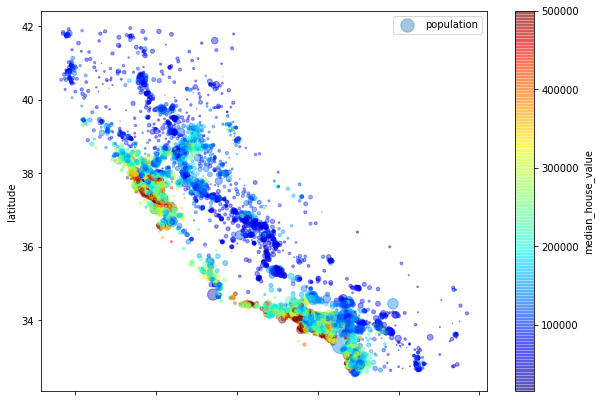

In [27]:
viz_df.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.4,
    s=viz_df.get('population')/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)
plt.legend()
plt.show()

In [28]:
corr_matrix = viz_df.corr()

In [29]:
corr_matrix.get('median_house_value').sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [8]:
from pandas.plotting import scatter_matrix

In [31]:
attributes=['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

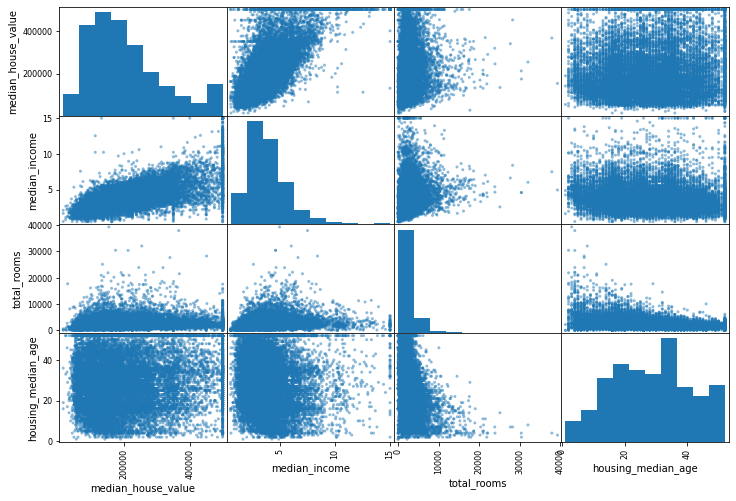

In [32]:
scatter_matrix(viz_df[attributes], figsize=(12,8))
plt.show()

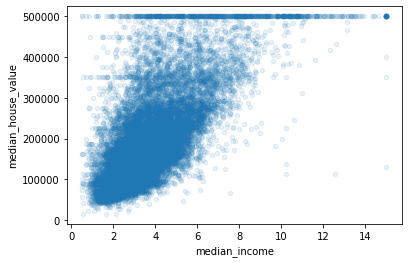

In [33]:
viz_df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

In [34]:
viz_df['rooms_per_household'] = viz_df['total_rooms']/viz_df['households']
viz_df['bedrooms_per_room'] = viz_df['total_bedrooms']/viz_df['households']
viz_df['population_per_household'] = viz_df['population']/viz_df['households']

In [35]:
viz_df.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   

      ocean_proximity  rooms_per_household  bedrooms_per_room  \
17606       <1H OCEAN             4.625369           1.035398   
18632       <1H OCEAN             6.008850           0.955752   

       population_per_household  
17606                  2.094395  
18632                  2.707965

In [36]:
corr_matrix = viz_df.corr()

In [37]:
corr_matrix.get('median_house_value').sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
bedrooms_per_room          -0.043343
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

## STEP 5: **Preparing data** for algorithms
- Data cleaning
- Categorical encoding
- Custom transformers
- Feature scaling
- Transformation pipelines

In [38]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.get('median_house_value').copy()

#### Data Cleaning

In [39]:
#options
#1. housing.dropna(subset=["total_bedrooms"])
#2. housing.drop(total_bedrooms", axis=1)
#3. housing["total_bedrooms"].fillna(median, inplace=True)
# Use sklearn imputer

In [9]:
from sklearn.impute import SimpleImputer

In [41]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
X = imputer.transform(housing_num)

In [43]:
#converting nd array to df
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214

- Scikit-learn Estimators estimate parameters based on a dataset using a fit() method
- Scikit-learn Transformers estimate parameters using a fit() method and then transform the data using a transform() method (or fit_transform() method)
- Scikit-learn Predictors estimate parameters using a fit() method and then can make predictions using a predict() method & measure with score() method)

NB - Shortcuts: **M** for **markdown** or **Y** for **code**

#### Categorical Encoding

In [44]:
housing_cat = housing[['ocean_proximity']]

In [10]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [46]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [47]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

To avoid taking distance between values into consideration, binary attributes for catogries are used ie one-hot encoding..(embedding for large possibilities)

In [11]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [49]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [50]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Custom Transformers

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

Note:  2 × 3 (read "two by three" matrix): there are two rows and three columns

In [52]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttibutesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

NB: NDArray dimensions (concatenation - np.c_)

In [53]:
np.c_[np.array([1,2,3]), np.array([4,5,6]), np.array([7,8,9])]

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [54]:
np.c_[np.array([[1,2,3]]), np.array([[4,5,6]]), np.array([[7,8,9]])]

array([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [55]:
np.c_[np.array([[1,2,3],[1,22,23],[31,32,33]]), np.array([4,5,6]), np.array([7,8,9])]

array([[ 1,  2,  3,  4,  7],
       [ 1, 22, 23,  5,  8],
       [31, 32, 33,  6,  9]])

In [56]:
attr_adder = CombinedAttibutesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [57]:
pd.DataFrame(housing_extra_attribs).head(2)

0      1   2     3    4    5    6       7          8        9        10
0 -121.89  37.29  38  1568  351  710  339  2.7042  <1H OCEAN  4.62537   2.0944
1 -121.93  37.05  14   679  108  306  113  6.4214  <1H OCEAN  6.00885  2.70796

In [58]:
housing.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN

#### Feature Scaling
- min-max scaling
- standardization

NB: Standardization is less affected by outliers, but does not bound values to a specific range (neural networks for example expect inputs within 0-1)

#### NOTE!!! As with transformation, its important to fit the scalers to the **training data only**, and not to full dataset

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### Transformation pipielines

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [61]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttibutesAdder()),
    ('std_scaler', StandardScaler())
])

In [62]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [63]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [64]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [65]:
housing_prepared = full_pipeline.fit_transform(housing)

In [66]:
pd.DataFrame(housing_prepared).head(1)

0        1         2         3         4         5         6   \
0 -1.156043  0.77195  0.743331 -0.493234 -0.445438 -0.636211 -0.420698   

         7         8         9         10   11   12   13   14   15  
0 -0.614937 -0.312055 -0.086499  0.155318  1.0  0.0  0.0  0.0  0.0

## STEP 6: Select Algorithm and **Train Model**
- Select model
- Train model
- Evaluate Accuracy
     - Cross validation

#### Select model

In [15]:
from sklearn.linear_model import LinearRegression

#### Train model

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)  # Training the model

LinearRegression()

In [70]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [71]:
#Testing the model on sample data
some_data_prepared = full_pipeline.transform(some_data)

In [72]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [73]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


#### Evaluate Accuracy

In [16]:
from sklearn.metrics import mean_squared_error

In [75]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

#### Causes for poor performance
- Data Related
    - Insufficiency of data
    - Non representative training data (sampling bias)
    - Poor quality data (outliers, missing values)
    - Irrelevant Features (solutions- Feature selection/extraction/creation)
- Algorithm related
    - Overfitting training data (solutions- regularization ie simplify model with fewer parameters eg increase regularization hyper-parameter, use more training data, reduce noise in data)
    - Underfitting the training data (solutions- select more powerful model with more parameters, use better features, reduce contraints on model eg reduce regularization hyper parameter)

In [17]:
# Trying a decision tree regressor
from sklearn.tree import DecisionTreeRegressor

In [77]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [78]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score

In [80]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

NOTE: Utility Function - greater is better; Cost Function-lower is better
sklearn cross val features expect utility function, thus scoring function is opposite of mse ie a negative value

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [82]:
display_scores(tree_rmse_scores)

Scores: [69684.83135593 67832.99581049 71747.78326828 68780.36176074
 70628.95561032 73727.29294215 70267.50029777 71942.16711363
 76022.80826449 69693.77304419]
Mean: 71032.84694679859
Standard deviation: 2305.854196304466


In [20]:
# Trying random forest regressor
from sklearn.ensemble import RandomForestRegressor

In [84]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [85]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18719.679558481304

In [86]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [87]:
display_scores(forest_rmse_scores)

Scores: [49470.82328757 47759.58596896 50393.03583515 52614.25013447
 49353.21717229 53561.05317639 48953.92849255 48114.77126417
 52971.07464654 50365.52421935]
Mean: 50355.72641974433
Standard deviation: 1942.4604074815836


#### Saving Model to file (and loading model)

In [21]:
import joblib

In [89]:
MODEL_PATH = os.path.join("datasets", "model_files")
storage_path = os.path.join(MODEL_PATH, "first_sample_model.pkl")

In [90]:
joblib.dump(forest_reg, storage_path)

['datasets\\model_files\\first_sample_model.pkl']

In [91]:
test_reg = joblib.load(storage_path)

In [92]:
housing_predictions_test = test_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions_test)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18719.679558481304

## STEP 7: **Fine-tuning models**
- grid search hyperparameter tuning
- randomized search hyperparameter tuning
- ensemble learning model combination

#### Sklearn **GridSearchCV** using cross-validation to evaluate all possible combinations of hyperparameters

In [22]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

In [95]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [96]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [97]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [98]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [99]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

64029.06665553471 {'max_features': 2, 'n_estimators': 3}
55581.09081440206 {'max_features': 2, 'n_estimators': 10}
53059.56536800798 {'max_features': 2, 'n_estimators': 30}
60459.40731709671 {'max_features': 4, 'n_estimators': 3}
52857.44901878359 {'max_features': 4, 'n_estimators': 10}
50646.933110334976 {'max_features': 4, 'n_estimators': 30}
58948.96674415503 {'max_features': 6, 'n_estimators': 3}
52309.64942469161 {'max_features': 6, 'n_estimators': 10}
49551.902957577055 {'max_features': 6, 'n_estimators': 30}
57897.949818297515 {'max_features': 8, 'n_estimators': 3}
52625.36100467977 {'max_features': 8, 'n_estimators': 10}
50161.467079474925 {'max_features': 8, 'n_estimators': 30}
61123.28104111469 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54695.123268457945 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59665.00556703893 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52970.99608390146 {'bootstrap': False, 'max_features': 3, 'n_estimators

#### Sklearn **RandomizedSearchCV** provides a better alternative when hyperparameter space is large byusing random combinations of hyperparameters

#### **Ensemble methods** involves combining multiple models

## STEP 8: **Analyzing best model** and important features

In [100]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [101]:
feature_importances

array([7.71999510e-02, 6.41761859e-02, 4.13466013e-02, 1.80743293e-02,
       1.65073978e-02, 1.75733613e-02, 1.65233221e-02, 3.47150876e-01,
       5.29251443e-02, 1.06613153e-01, 7.81365040e-02, 1.40301309e-02,
       1.33343613e-01, 5.67930300e-05, 8.31373667e-03, 8.02890131e-03])

In [102]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [103]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34715087560658164, 'median_income'),
 (0.1333436128847262, 'INLAND'),
 (0.10661315266187808, 'pop_per_hhold'),
 (0.07813650395043041, 'bedrooms_per_room'),
 (0.07719995099037352, 'longitude'),
 (0.06417618592787537, 'latitude'),
 (0.05292514425642554, 'rooms_per_hhold'),
 (0.04134660131651259, 'housing_median_age'),
 (0.018074329285885673, 'total_rooms'),
 (0.01757336129478811, 'population'),
 (0.01652332213334421, 'households'),
 (0.016507397774829506, 'total_bedrooms'),
 (0.01403013090027088, '<1H OCEAN'),
 (0.00831373667165271, 'NEAR BAY'),
 (0.008028901314406568, 'NEAR OCEAN'),
 (5.6793030019092785e-05, 'ISLAND')]

For example extra ocen proximity features are less usefull and could be dropped

## STEP 9: **Evaluating** model on **test set**

In [104]:
final_model = grid_search.best_estimator_

In [105]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

In [106]:
X_test_prepared = full_pipeline.transform(X_test)

In [107]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

Calculating 95% confidence interval

In [23]:
from scipy import stats

In [109]:
confidence = 0.95
squared_errors = (final_predictions - y_test)** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45674.72860512, 49546.978716  ])

In [110]:
final_model.predict([[0.592384, -0.710749, 0.027588, 1.788385, 1.163511, 0.684989, 1.232174, 2.312998, 0.488309, -0.070908, -0.868201, 1.0, 0.0, 0.0, 0.0, 0.0]])

array([481867.46666667])

In [111]:
final_model.predict(full_pipeline.transform(pd.DataFrame([[122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, '<1H OCEAN']], columns=X_test.columns)))

array([405843.53333333])

In [112]:
y_test.iloc[0]

500001.0

In [113]:
pd.DataFrame(X_test_prepared, columns=num_attribs+extra_attribs+cat_one_hot_attribs).head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.592384 -0.710749            0.027588     1.788385        1.163511   

   population  households  median_income  rooms_per_hhold  pop_per_hhold  \
0    0.684989    1.232174       2.312998         0.488309      -0.070908   

   bedrooms_per_room  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
0          -0.868201        1.0     0.0     0.0       0.0         0.0

In [114]:
housing_df.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   

  income_cat  
0          5

In [115]:
X_test.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5241    -118.39     34.12                29.0       6447.0          1012.0   

      population  households  median_income ocean_proximity  
5241      2184.0       960.0         8.2816       <1H OCEAN

In [116]:
X_test.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

## Regression Theory

#### Normal Equation
- Closed form equation to minimize cost function (NB: Slow with large n i.e. features)

$$ \theta = (X^T * X)^{-1} * X^T * y $$

In [35]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1) #i.e. y= 4 + 3X + gaussian noise

In [36]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

In [37]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [38]:
theta_best

array([[4.30061164],
       [2.65759019]])

#### Singular Value Decomposition

$$ \theta = X^+ * y $$

where X^+ is the pseudoinverse of X

In [39]:
np.linalg.pinv(X_b).dot(y)

array([[4.30061164],
       [2.65759019]])

#### Stochastic Gradient Descent

In [24]:
from sklearn.linear_model import SGDRegressor

In [42]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel returns flattened array, penalty being regularization type

SGDRegressor(eta0=0.1, penalty=None)

In [43]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.35594909]), array([2.75413139]))

#### Batch Gradient Descent

In [46]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [47]:
theta

array([[4.30061164],
       [2.65759019]])

#### Mini-batch gradient descent
- involves using the stochastic gradient descent approach but with small random sets of instances (instead of one instance - SGD or all instances - BGD)

#### Comparison of Linear Regression Algorithms

| Algorithm      | Large m (instances) | Out of core support     | Large n (features)     | Hyperparams     | Needs Scaling     | Scikit Learn package     |
|    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |    :----:   |
| Normal Equation      | Fast       | No   | Slow   | 0   | No   | NA   |
| SVD   | Fast        | No      | Slow   | 0   | No   | Linear Regressor   |
| Batch GD   | Slow        | No      | Fast   | 2   | Yes   | SGD Regressor   |
| Stochastic GD   | Fast        | Yes      | Fast   | 2 or more   | Yes   | SGD Regressor   |
| MiniBatch GD   | Fast        | Yes      | Fast   | 2 or more   | Yes   | SGD Regressor   |

#### Polynomial Regression

In [25]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [49]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [51]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [52]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

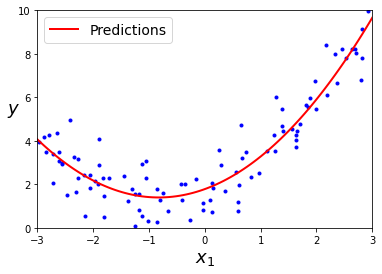

In [55]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

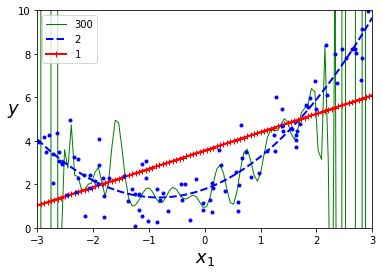

In [56]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [27]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

underfitting_learning_curves_plot


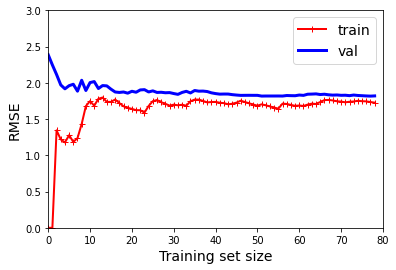

In [59]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
print("underfitting_learning_curves_plot")
plt.show()

Overfitting_learning_curves_plot


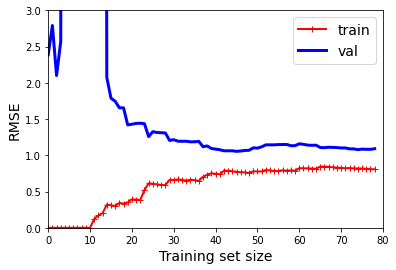

In [60]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3]) 
print("Overfitting_learning_curves_plot")
plt.show()

#### Regularization

In [61]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [28]:
from sklearn.linear_model import Ridge

###### closed-form equation variant of cholesky which uses matrix factorization

In [63]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.70746731]])

###### Stochastic average GD variant of ridge regression

In [64]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.70747046]])

In [65]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

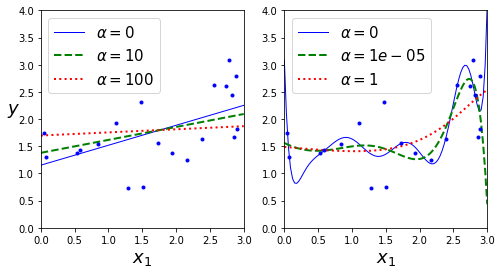

In [66]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

###### Adding l2 as penalty to SGD Regressor is simply ridge regression
- i.e. it adds half the square of l2 norm of the weight vector to the cost function

In [67]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.50653461])

from sklearn.linear_model import Lasso

###### Lasso regression (Least Absolute Shrinkage and Selection Operator)
- adds a  regularization term to the cost function using l1 norm of the weight vector

In [29]:
from sklearn.linear_model import Lasso

/Users/uche/.local/share/virtualenvs/ml_clustering-IlWZg_sG/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.994771631705535, tolerance: 0.0008185452350507114
  model = cd_fast.enet_coordinate_descent(


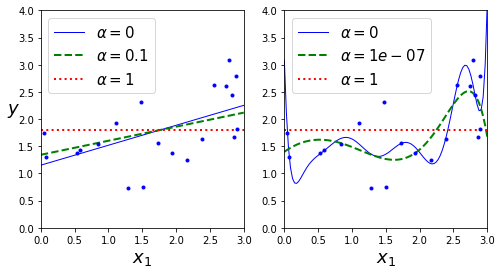

In [68]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.show()

In [69]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.73090508])

###### Elastic Net 

In [30]:
from sklearn.linear_model import ElasticNet

In [70]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.72092592])

#### EARLY STOPPING

In [31]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [32]:
from copy import deepcopy

In [37]:
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

early_stopping_plot


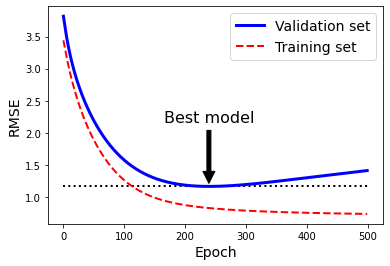

In [38]:
# Plotting results
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
print("early_stopping_plot")
plt.show()

In [34]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))